# Learning to Reweight Examples
## ECE 50024
### Joel Peterson

In [1]:
import torch
from model import *
from model_other import *
from data_loader import *
from helper import *
import ssl
import torchvision
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import IPython

%load_ext autoreload
%autoreload 2

In [2]:
# Debugging HTTPS error
ssl._create_default_https_context = ssl._create_unverified_context
        
torchvision.datasets.CIFAR10.url="http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

In [3]:
# Define hyperparams and use CUDA
hyperparams = {
    'batch_size' : 1024,
    'num_classes' : 2,
    'lr' : 5e-3,
    'n_epochs' : 25000
}

device = torch.device('cuda')

In [4]:
train_data_loader = get_loader(hyperparams['batch_size'], proportion=0.8)
test_data_loader = get_loader(hyperparams['batch_size'], proportion=0.5, type='test')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
norm_3d = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
val_data = to_var(norm_3d(train_data_loader.dataset.val_data.permute(0,3,1,2)), grad=False)
val_labels = to_var(train_data_loader.dataset.val_labels, grad=False)

Show batch size and tensors, and labels being a majority of one class
Show images

torch.Size([1024, 3, 32, 32]) tensor([1., 1., 0.,  ..., 1., 1., 1.])


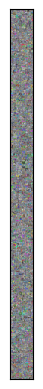

In [6]:
for i,(img, label) in enumerate(train_data_loader):
    print(img.size(),label)
    grid = torchvision.utils.make_grid(img)
    show(grid)
    break

Test data has more balanced labels

torch.Size([1024, 3, 32, 32]) tensor([1., 1., 0.,  ..., 1., 1., 1.])


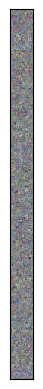

In [7]:
for i,(img,label) in enumerate(test_data_loader):
    print(img.size(),label)
    grid = torchvision.utils.make_grid(img)
    show(grid)
    break

## My baseline try

In [8]:
# class Trainer:
#     def __init__(self, net, data, device, hp):
        
#         self.model = net
#         self.train_loader, self.test_loader = data
#         self.loss_func = F.binary_cross_entropy_with_logits()
#         self.opt = torch.optim.Adam(self.model.parametsrs(), lr = hp['lr'])
#         self.device = device
        
#         def accuracy(out, y):
#             pred = (out > 0.5).int()
#             return torch.cat(pred == y.int()).float().mean()
        
#         def train_iter(self):
            
#             loss = 0
#             acc = 0
            
            

In [9]:
# baseline, opt = base_model(hyperparams['lr'])

# iters_plot = 1
# acc = []

# for i in tqdm(range(hyperparams['n_epochs'])):
#     baseline.train()
#     x, y = next(iter(train_data_loader))
    
#     x = to_var(x, grad=False)
#     y = to_var(y, grad=False)

#     y_pred = baseline(x)
#     loss = F.binary_cross_entropy_with_logits(y_pred, y)
    
#     opt.zero_grad()
#     loss.backward()
#     opt.step()
    
#     if i % iters_plot == 0:
#         baseline.eval()
        
#         inst_acc = []
#         for j,(x_test, y_test) in enumerate(test_data_loader):
#             x_test = to_var(x_test, grad=False)
#             y_test = to_var(y_test, grad=False)

#             pred = (F.sigmoid(baseline(x_test) > 0.5)).int()
            
#             inst_acc.append((pred == y_test.int()).float())
            
#         acc.append(torch.cat(inst_acc,dim=0).mean())
        
#         plt.plot(acc)
#         plt.show()
        

## Other implementation of training baseline

In [10]:
def build_model():
    net = LeNet(n_out=1)

    if torch.cuda.is_available():
        net.cuda()
        torch.backends.cudnn.benchmark=True

    opt = torch.optim.SGD(net.params(),lr=hyperparams["lr"])
    
    return net, opt

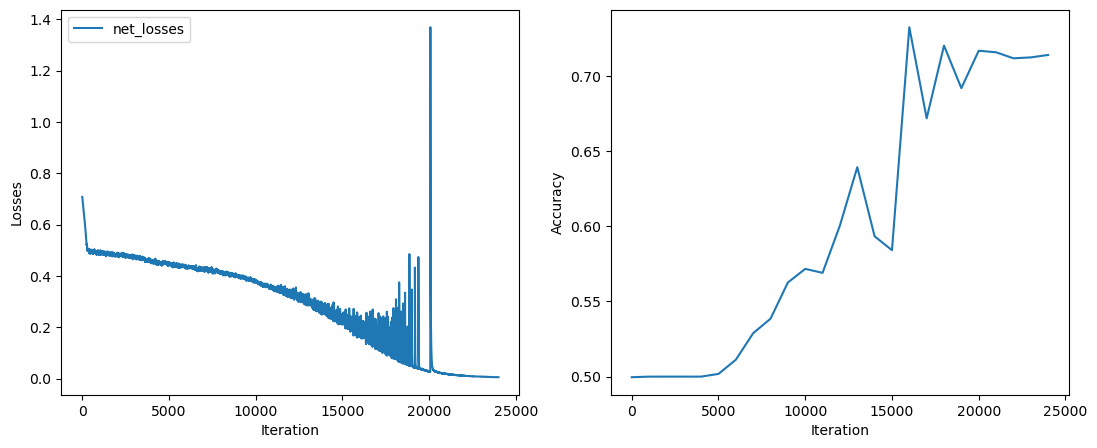

100%|██████████| 25000/25000 [48:36<00:00,  8.57it/s]


In [11]:
net, opt = build_model()

net_losses = []
plot_step = 1000
net_l = 0

smoothing_alpha = 0.9
accuracy_log = []
for i in tqdm(range(hyperparams['n_epochs'])):
    net.train()
    image, labels = next(iter(train_data_loader))

    image = to_var(image, grad=False)
    labels = to_var(labels, grad=False)

    y = net(image)
    cost = F.binary_cross_entropy_with_logits(y, labels)
    
    opt.zero_grad()
    cost.backward()
    opt.step()
    
    net_l = smoothing_alpha *net_l + (1 - smoothing_alpha)* cost.item()
    net_losses.append(net_l/(1 - smoothing_alpha**(i+1)))
    
    if i % plot_step == 0:
        net.eval()
        
        acc = []
        for itr,(test_img, test_label) in enumerate(test_data_loader):
            test_img = to_var(test_img, grad=False)
            test_label = to_var(test_label, grad=False)
            
            output = net(test_img)
            predicted = (F.sigmoid(output) > 0.5).int()
            
            acc.append((predicted.int() == test_label.int()).float())

        accuracy = torch.cat(acc,dim=0).mean()
        accuracy_log.append(np.array([i,accuracy.cpu()])[None])
        
        
        IPython.display.clear_output()
        fig, axes = plt.subplots(1, 2, figsize=(13,5))
        ax1, ax2 = axes.ravel()

        ax1.plot(net_losses, label='net_losses')
        ax1.set_ylabel("Losses")
        ax1.set_xlabel("Iteration")
        ax1.legend()
        
        acc_log = np.concatenate(accuracy_log, axis=0)
        ax2.plot(acc_log[:,0],acc_log[:,1])
        ax2.set_ylabel('Accuracy')
        ax2.set_xlabel('Iteration')
        plt.show()

In [12]:
def train_lre():
    net, opt = build_model()
    
    meta_losses_clean = []
    net_losses = []
    plot_step = 250

    smoothing_alpha = 0.9
    
    meta_l = 0
    net_l = 0
    accuracy_log = []
    for i in tqdm(range(hyperparams['n_epochs'])):
        net.train()
        # Line 2 get batch of data
        image, labels = next(iter(data_loader))
        # since validation data is small I just fixed them instead of building an iterator
        # initialize a dummy network for the meta learning of the weights
        meta_net = LeNet(n_out=1)
        meta_net.load_state_dict(net.state_dict())

        if torch.cuda.is_available():
            meta_net.cuda()

        image = to_var(image, grad=False)
        labels = to_var(labels, grad=False)

        # Lines 4 - 5 initial forward pass to compute the initial weighted loss
        y_f_hat  = meta_net(image)
        y_f_hat_meta = y_f_hat
        cost = F.binary_cross_entropy_with_logits(y_f_hat,labels, reduce=False)
        eps = to_var(torch.zeros(cost.size()))
        l_f_meta = torch.sum(cost * eps)

        meta_net.zero_grad()
        
        # Line 6 perform a parameter update
        grads = torch.autograd.grad(l_f_meta, (meta_net.params()), create_graph=True)
        meta_net.update_params(hyperparams['lr'], source_params=grads)
        
        # Line 8 - 10 2nd forward pass and getting the gradients with respect to epsilon
        y_g_hat = meta_net(val_data)

        l_g_meta = F.binary_cross_entropy_with_logits(y_g_hat,val_labels)

        grad_eps = torch.autograd.grad(l_g_meta, eps, only_inputs=True)[0]
        
        # Line 11 computing and normalizing the weights
        w_tilde = torch.clamp(-grad_eps,min=0)
        norm_c = torch.sum(w_tilde)

        if norm_c != 0:
            w = w_tilde / norm_c
        else:
            w = w_tilde

        # Lines 12 - 14 computing for the loss with the computed weights
        # and then perform a parameter update
        y_f_hat = net(image)
        equality = torch.sum(torch.eq(y_f_hat, y_f_hat_meta)).item()
        cost = F.binary_cross_entropy_with_logits(y_f_hat, labels, reduce=False)
        l_f = torch.sum(cost * w)

        opt.zero_grad()
        l_f.backward()
        opt.step()

        meta_l = smoothing_alpha *meta_l + (1 - smoothing_alpha)* l_g_meta.item()
        meta_losses_clean.append(meta_l/(1 - smoothing_alpha**(i+1)))

        net_l = smoothing_alpha *net_l + (1 - smoothing_alpha)* l_f.item()
        net_losses.append(net_l/(1 - smoothing_alpha**(i+1)))

        if i % plot_step == 0:
            net.eval()

            acc = []
            for itr,(test_img, test_label) in enumerate(test_data_loader):
                test_img = to_var(test_img, grad=False)
                test_label = to_var(test_label, grad=False)

                output = net(test_img)
                predicted = (F.sigmoid(output) > 0.5).int()

                acc.append((predicted.int() == test_label.int()).float())

            accuracy = torch.cat(acc,dim=0).mean()
            accuracy_log.append(np.array([i,accuracy.cpu()])[None])


            IPython.display.clear_output()
            fig, axes = plt.subplots(1, 2, figsize=(13,5))
            ax1, ax2 = axes.ravel()

            ax1.plot(meta_losses_clean, label='meta_losses_clean')
            ax1.plot(net_losses, label='net_losses')
            ax1.set_ylabel("Losses")
            ax1.set_xlabel("Iteration")
            ax1.legend()

            acc_log = np.concatenate(accuracy_log, axis=0)
            ax2.plot(acc_log[:,0],acc_log[:,1])
            ax2.set_ylabel('Accuracy')
            ax2.set_xlabel('Iteration')
            plt.show()
            
        # return accuracy
    return np.mean(acc_log[-6:-1, 1])

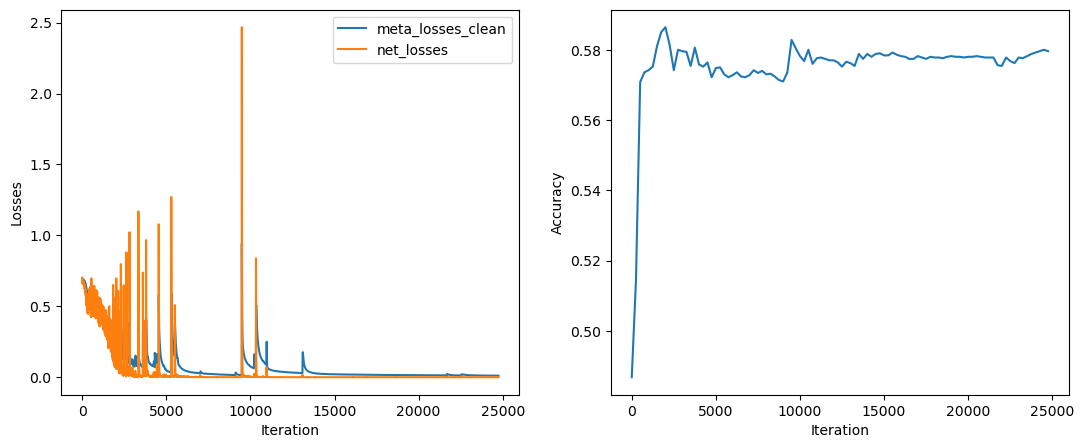

100%|██████████| 25000/25000 [55:47<00:00,  7.47it/s]


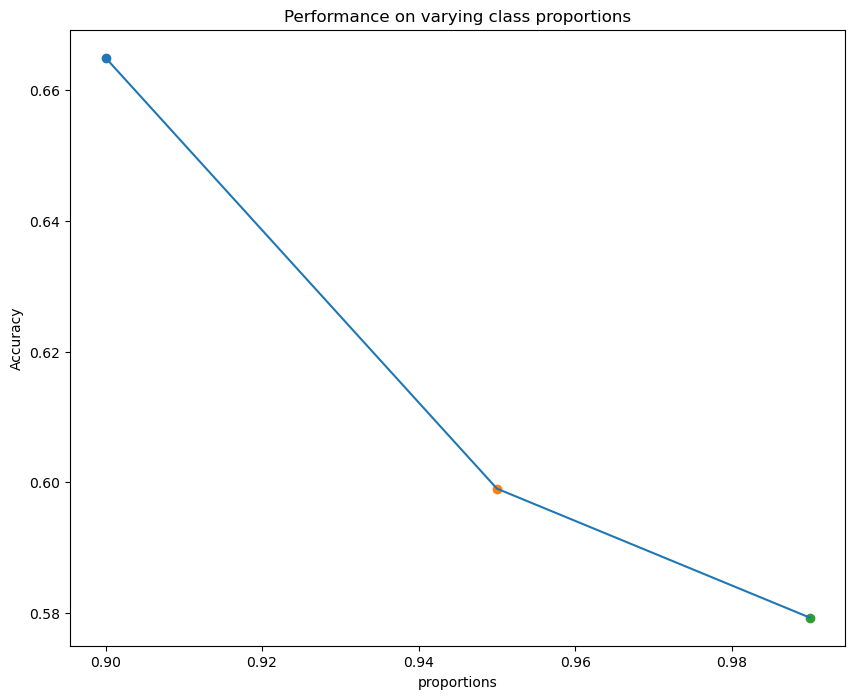

In [13]:
num_repeats = 1 #5
proportions = [0.9, 0.95, 0.99] # [0.9,0.95, 0.98, 0.99, 0.995]
accuracy_log = {}

for prop in proportions:
    data_loader = get_loader(hyperparams['batch_size'], proportion=prop, type="train")
    
    norm_3d = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    val_data = to_var(norm_3d(data_loader.dataset.val_data.permute(0,3,1,2)), grad=False)
    val_labels = to_var(data_loader.dataset.val_labels, grad=False)
    
    for k in range(num_repeats):
        accuracy = train_lre()
        
        if prop in accuracy_log:
            accuracy_log[prop].append(accuracy)
        else:
            accuracy_log[prop] = [accuracy]

plt.figure(figsize=(10,8))
for prop in proportions:
    accuracies = accuracy_log[prop]
    plt.scatter([prop] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(accuracy_log.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(accuracy_log.items())])
plt.errorbar(proportions, accuracies_mean, yerr=accuracies_std)
plt.title('Performance on varying class proportions')
plt.xlabel('proportions')
plt.ylabel('Accuracy')
plt.show()

In [14]:
def train_lre2(plot_step):
    # Get model and put in train mode
    model, opt = build_model()
    model.train()
    
    # Initialize loss variables
    model_losses = []
    model_l = 0    
    val_losses = []
    val_l = 0
    
    accuracy_log = []
    for i in tqdm(range(hyperparams['n_epochs'])):
        
        # Create copy of model to do first pass through before training with weights
        # remake this each time otherwise GPU usage explodes from tracking this 
        model_pred = LeNet(n_out=1)
        
        # Get next mini-batch from data loader
        image, labels = next(iter(data_loader))
        
        # Load in training model's state to other model to calculate first pass through
        model_pred.load_state_dict(model.state_dict())

        # Send it all to the GPU
        if torch.cuda.is_available():
            model_pred.cuda()
        image = to_var(image, grad=False)
        labels = to_var(labels, grad=False)

        # Forward pass for weighted loss
        y_f_hat  = model_pred(image)
        cost = F.binary_cross_entropy_with_logits(y_f_hat,labels, reduce=False)
        eps = to_var(torch.zeros(cost.size()))
        l_f = torch.sum(cost * eps)
        
        # Zero out gradients then calculate, need graph so we can do higher order grads
        model_pred.zero_grad()
        grads = torch.autograd.grad(l_f, (model_pred.params()), create_graph=True)
        model_pred.update_params(hyperparams['lr'], source_params=grads)
        
        # Validation forward pass
        y_g_hat = model_pred(val_data)
        l_g = F.binary_cross_entropy_with_logits(y_g_hat,val_labels)
        grad_eps = torch.autograd.grad(l_g, eps)[0]
        
        # Weights can't be less than zero
        w_tilde = torch.clamp(-grad_eps,min=0)
        
        # Normalize weights, accounting for divide by zero case
        sum_w_tilde = torch.sum(w_tilde)        
        w = w_tilde / (sum_w_tilde + (sum_w_tilde==0))

        # Training model forward pass, use calculated weights in the loss
        y_f_hat = model(image)
        cost = F.binary_cross_entropy_with_logits(y_f_hat, labels, reduce=False)
        l_f_hat = torch.sum(cost * w)

        # Backward pass on loss for theta gradient, before optimizer step with our theta grad
        # on the weighted loss
        opt.zero_grad()
        l_f_hat.backward()
        opt.step()

        # Get losses and append to running loss lists
        model_l = l_f_hat.item()
        model_losses.append(model_l)
        
        val_l = l_g.item()
        val_losses.append(val_l)

        # Plot when we reach plot step multiples
        if i % plot_step == 0:
            
            # Put model in eval mode to not update gradients
            model.eval()

            acc = []
            for itr,(test_img, test_label) in enumerate(test_data_loader):
                test_img = to_var(test_img, grad=False)
                test_label = to_var(test_label, grad=False)

                output = model(test_img)
                predicted = (F.sigmoid(output) > 0.5).int()

                acc.append((predicted.int() == test_label.int()).float())

            accuracy = torch.cat(acc,dim=0).mean()
            accuracy_log.append(np.array([i,accuracy.cpu()])[None])


            IPython.display.clear_output()
            fig, axes = plt.subplots(1, 2, figsize=(13,5))
            ax1, ax2 = axes.ravel()

            ax1.plot(model_losses, label='model_losses')
            ax1.plot(val_losses, label='validation_losses')
            ax1.set_ylabel("Losses")
            ax1.set_xlabel("Iteration")
            ax1.legend()

            acc_log = np.concatenate(accuracy_log, axis=0)
            ax2.plot(acc_log[:,0],acc_log[:,1])
            ax2.set_ylabel('Accuracy')
            ax2.set_xlabel('Iteration')
            plt.show()
            
            model.train()
            
        # return accuracy
    return np.mean(acc_log[-6:-1, 1])

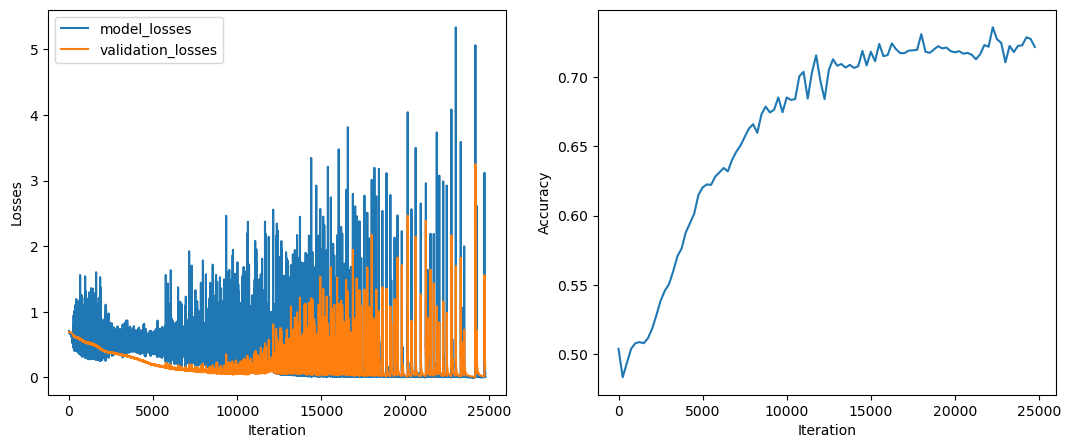

100%|██████████| 25000/25000 [54:59<00:00,  7.58it/s]


In [15]:
# Parameters for training
p = 0.8
p_step = 250

data_loader = get_loader(hyperparams['batch_size'], proportion=p, type="train")

# Normalize validation data
norm_3d = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
val_data = to_var(norm_3d(data_loader.dataset.val_data.permute(0,3,1,2)), grad=False)
val_labels = to_var(data_loader.dataset.val_labels, grad=False)

# Train
accuracy = train_lre2(p_step)